In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re

import nltk
import plotly_express as px
import configparser

In [2]:
config = configparser.ConfigParser()
config.read("env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

Named table blocks as "sentence" level

SCENE as chapter blocks

FADE IN FADE OUT as paragraph blocks

In [3]:
# based on OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num'], we do

OHCO = ['screenplay_id', 'scene_num', 'shot_num', 'line_num', 'token_num']

In [4]:
import sys
sys.path.append(local_lib)

In [5]:
source_files = f'{data_home}/entrepreneur'
data_prefix = 'entrepreneur'
from textparser2 import TextParser

#### Register

In [6]:
source_file_list = sorted(glob(f"{source_files}/*.*"))
source_file_list

['/sfs/weka/scratch/gec2tp/data/entrepreneur/Joy.txt',
 '/sfs/weka/scratch/gec2tp/data/entrepreneur/Steve_Jobs.txt',
 '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Big_Short.txt',
 '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Founder.txt',
 '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Help.txt',
 '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Social_Network.txt']

In [7]:
screenplay_data = []
for source_file_path in source_file_list:
    screenplay_id = source_file_path.split('/')[-1].split('.')[0].replace('txt', '_').lower()
    screenplay_title = source_file_path.split('/')[-1].split('.')[0].replace('_', ' ')
    screenplay_data.append((screenplay_id, source_file_path, screenplay_title))
    
screenplay_data

[('joy', '/sfs/weka/scratch/gec2tp/data/entrepreneur/Joy.txt', 'Joy'),
 ('steve_jobs',
  '/sfs/weka/scratch/gec2tp/data/entrepreneur/Steve_Jobs.txt',
  'Steve Jobs'),
 ('the_big_short',
  '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Big_Short.txt',
  'The Big Short'),
 ('the_founder',
  '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Founder.txt',
  'The Founder'),
 ('the_help',
  '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Help.txt',
  'The Help'),
 ('the_social_network',
  '/sfs/weka/scratch/gec2tp/data/entrepreneur/The_Social_Network.txt',
  'The Social Network')]

In [8]:
LIB = pd.DataFrame(screenplay_data, columns=['screenplay_id','source_file_path','raw_title'])\
    .set_index('screenplay_id').sort_index()
LIB

,source_file_path,raw_title
screenplay_id,,
joy,/sfs/weka/scratch/gec2tp/data/entrepreneur/Joy...,Joy
steve_jobs,/sfs/weka/scratch/gec2tp/data/entrepreneur/Ste...,Steve Jobs
the_big_short,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Big Short
the_founder,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Founder
the_help,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Help
the_social_network,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Social Network


In [9]:
try:
    LIB['year'] = LIB.raw_title.apply(lambda x: ', '.join(x.split()[:1]))
    LIB['title'] = LIB.raw_title.apply(lambda x: ' '.join(x.split()[1:]))
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass

In [123]:
LIB

,source_file_path,year,title
screenplay_id,,,
1938_the_lady_vanishes,/sfs/weka/scratch/gec2tp/data/Hitch/1938_The_L...,1938,The Lady Vanishes
1941_suspicion,/sfs/weka/scratch/gec2tp/data/Hitch/1941_Suspi...,1941,Suspicion
1943_shadow_of_a_doubt,/sfs/weka/scratch/gec2tp/data/Hitch/1943_Shado...,1943,Shadow Of A Doubt
1948_rope,/sfs/weka/scratch/gec2tp/data/Hitch/1948_Rope.txt,1948,Rope
1951_strangers_on_a_train,/sfs/weka/scratch/gec2tp/data/Hitch/1951_Stran...,1951,Strangers On A Train
1959_north_by_northwest,/sfs/weka/scratch/gec2tp/data/Hitch/1959_North...,1959,North by NorthWest
1960_psycho,/sfs/weka/scratch/gec2tp/data/Hitch/1960_Psych...,1960,Psycho
1963_the_birds,/sfs/weka/scratch/gec2tp/data/Hitch/1963_The_B...,1963,The Birds


### LIB

In [9]:
scene_pats = [
    ('joy', r'^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)'),
    ('steve_jobs', r'^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)'),
    ('the_big_short', r'^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)'),
    ('the_founder', r'^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)'),
    ('the_help', r'^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)'),
    ('the_social_network', r'^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)')
]
shot_pats = [
    ('joy', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|SHOT|PAN|CLOSE ON).*'),
    ('steve_jobs', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|SHOT|CLOSE ON|INTERCUT).*'),
    ('the_big_short', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|FREEZE FRAME|MONTAGE|TEXT|GRAPHIC).*'),
    ('the_social_network', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|OVER BLACK|TEXT).*'),
    ('the_founder', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|TEXT|OVER BLACK).*'),
    ('the_help', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|TEXT|VOICE OVER).*'),
    ('the_aviator', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|SPLIT SCREEN|TITLE CARD).*'),
    ('the_wolf_of_wall_street', r'^(CAMERA|CUT TO|ANGLE|DISSOLVE TO|FREEZE FRAME|MONTAGE|TEXT|ZOOM IN).*')
]

line_pats = [
    ('joy', r'^[A-Z ]{2,30}$'),
    ('steve_jobs', r'^[A-Z ]{2,30}$'),
    ('the_big_short', r'^[A-Z ]{2,30}$'),
    ('the_social_network', r'^[A-Z ]{2,30}$'),
    ('the_founder', r'^[A-Z ]{2,30}$'),
    ('the_help', r'^[A-Z ]{2,30}$'),
    ('the_aviator', r'^[A-Z ]{2,30}$'),
    ('the_wolf_of_wall_street', r'^[A-Z ]{2,30}$')
]

# Create a dictionary mapping screenplay_id to regex
scene_dict = dict(scene_pats)
shot_dict = dict(shot_pats)
line_dict = dict(line_pats)

LIB = LIB.reset_index()
# Map the correct regex to each row in LIB
LIB['scene_regex'] = LIB['screenplay_id'].map(scene_dict)
#LIB['shot_regex'] = LIB['screenplay_id'].map(shot_dict)
#LIB['line_regex'] = LIB['screenplay_id'].map(line_dict)
LIB = LIB.set_index('screenplay_id')
LIB

,source_file_path,raw_title,scene_regex
screenplay_id,,,
joy,/sfs/weka/scratch/gec2tp/data/entrepreneur/Joy...,Joy,^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1...
steve_jobs,/sfs/weka/scratch/gec2tp/data/entrepreneur/Ste...,Steve Jobs,^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1...
the_big_short,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Big Short,^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1...
the_founder,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Founder,^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1...
the_help,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Help,^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1...
the_social_network,/sfs/weka/scratch/gec2tp/data/entrepreneur/The...,The Social Network,^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1...


## Tokenize

In [10]:
OHCO = ['screenplay_id', 'scene_num', 'para_num', 'sent_num', 'token_num']

In [13]:
def tokenize_collection(LIB):

    clip_pats_dict = {
        "joy": ["SCENE 1", r"SCENE\s+256\.?"],
        "steve_jobs": ["SCENE 1", r"SCENE\s+878\.?"],
        "the_help": ["SCENE 1", r"SCENE\s+345\.?"],
        "the_founder": ["SCENE 1", r"SCENE\s+264\.?"],
        "the_social_network": ["SCENE 1", r"SCENE\s+388\.?"],
        "the_big_short": ["SCENE 1", r"SCENE\s+529\.?"]
    }

    books = []
    for screenplay_id in LIB.index:

        # Announce
        print("Tokenizing", screenplay_id, LIB.loc[screenplay_id].raw_title)

        # Define vars
        scene_regex = LIB.loc[screenplay_id].scene_regex
        ohco_pats = [('chap', scene_regex, 'm')]
        src_file_path = LIB.loc[screenplay_id].source_file_path

        
        clip_pats = clip_pats_dict.get(screenplay_id, ["SCENE 1", r"SCENE\s+\d+\.?"])
        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)
        # text = TextImporter(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats) 

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['screenplay_id'] = screenplay_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['screenplay_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [26]:
print(pd.__version__)

2.2.3


In [82]:
pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 25.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
CORPUS = tokenize_collection(LIB)

Tokenizing joy Joy
Importing  /sfs/weka/scratch/gec2tp/data/entrepreneur/Joy.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model


/sfs/weka/scratch/gec2tp/textparser2.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Tokenizing steve_jobs Steve Jobs
Importing  /sfs/weka/scratch/gec2tp/data/entrepreneur/Steve_Jobs.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model


/sfs/weka/scratch/gec2tp/textparser2.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Parsing OHCO level 3 token_num by NLTK model
Tokenizing the_big_short The Big Short
Importing  /sfs/weka/scratch/gec2tp/data/entrepreneur/The_Big_Short.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model


/sfs/weka/scratch/gec2tp/textparser2.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Tokenizing the_founder The Founder
Importing  /sfs/weka/scratch/gec2tp/data/entrepreneur/The_Founder.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model


/sfs/weka/scratch/gec2tp/textparser2.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Tokenizing the_help The Help
Importing  /sfs/weka/scratch/gec2tp/data/entrepreneur/The_Help.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model


/sfs/weka/scratch/gec2tp/textparser2.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Parsing OHCO level 3 token_num by NLTK model
Tokenizing the_social_network The Social Network
Importing  /sfs/weka/scratch/gec2tp/data/entrepreneur/The_Social_Network.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(INT\.|EXT\.|INT/EXT\.|EXT/INT\.|SCENE\s+\d{1,4}[:\.-]?)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model


/sfs/weka/scratch/gec2tp/textparser2.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Parsing OHCO level 3 token_num by NLTK model
Done


In [17]:
CORPUS.head(20)
CORPUS = CORPUS.rename_axis(index = {"chap_id" : "scene_id"})

### VOCAB

In [18]:
CORPUS[CORPUS.term_str == '']

pos_tuple  pos  \
screenplay_id      scene_id para_num sent_num token_num                  
joy                39       0        5        5           (&, CC)   CC   
                   208      0        0        5           (&, CC)   CC   
                   226      3        0        3           (/, JJ)   JJ   
                   227      1        2        17          (/, NN)   NN   
                   254      0        5        3           (&, CC)   CC   
...                                                           ...  ...   
the_social_network 56       0        1        12          (=, NN)   NN   
                   58       0        0        7          (/, VBD)  VBD   
                   59       1        0        4           (=, NN)   NN   
                   61       0        0        7          (/, VBD)  VBD   
                   115      0        4        21          (&, CC)   CC   

                                                        token_str term_str  
screenplay_id      scene_id para_num sent_num token_num                     
joy                39       0        5        5                 &           
                   208      0        0        5                 &           
                   226      3        0        3                 /           
                   227      1        2        17                /           
                   254      0        5        3                 &           
...                                                           ...      ...  
the_social_network 56       0        1        12                =           
                   58       0        0        7                 /           
                   59       1        0        4                 =           
                   61       0        0        7                 /           
                   115      0        4        21                &           

[212 rows x 4 columns]

In [19]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

token_str
*       162
&        13
"        10
/         8
'         7
.)        3
."        2
=         2
(?)       1
!!        1
+...      1
..        1
'.        1
Name: count, dtype: int64

In [20]:
CORPUS = CORPUS[CORPUS.term_str != '']

In [21]:
CORPUS['pos_group'] = CORPUS.pos.str[:2]

In [22]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB

,n,n_chars,p,i
term_str,,,,
000,1,3,0.000007,17.199318
031915,188,6,0.001249,9.644729
05,4,2,0.000027,15.199318
07,4,2,0.000027,15.199318
0c,1,2,0.000007,17.199318
...,...,...,...,...
ﬂcalifornia,1,11,0.000007,17.199318
ﬂfriendsterﬂ,1,12,0.000007,17.199318
ﬂi,2,2,0.000013,16.199318


In [23]:
VOCAB['max_pos'] = CORPUS.groupby(['term_str', 'pos']).size().unstack(fill_value=0).idxmax(1)

In [24]:
VOCAB['max_pos_group'] = CORPUS.groupby(['term_str','pos_group']).size().unstack(fill_value=0).idxmax(1)

In [25]:
VOCAB['n_pos_group'] = CORPUS.groupby(['term_str','pos_group']).size().unstack(fill_value=0).idxmax(1)
VOCAB['cat_pos_group'] = CORPUS.groupby(['term_str','pos_group']).size().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))
VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group
term_str,,,,,,,,
000,1,3,0.000007,17.199318,CD,CD,CD,{CD}
031915,188,6,0.001249,9.644729,CD,CD,CD,{CD}
05,4,2,0.000027,15.199318,NN,NN,NN,{NN}
07,4,2,0.000027,15.199318,CD,CD,CD,"{CD, NN}"
0c,1,2,0.000007,17.199318,CD,CD,CD,{CD}
...,...,...,...,...,...,...,...,...
ﬂcalifornia,1,11,0.000007,17.199318,JJ,JJ,JJ,{JJ}
ﬂfriendsterﬂ,1,12,0.000007,17.199318,NN,NN,NN,{NN}
ﬂi,2,2,0.000013,16.199318,NN,NN,NN,{NN}


In [26]:
VOCAB['n_pos'] = CORPUS.groupby(['term_str','pos']).size().unstack().count(1)
VOCAB['cat_pos'] = CORPUS.groupby(['term_str','pos']).size().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos
term_str,,,,,,,,,,
000,1,3,0.000007,17.199318,CD,CD,CD,{CD},1,{CD}
031915,188,6,0.001249,9.644729,CD,CD,CD,{CD},1,{CD}
05,4,2,0.000027,15.199318,NN,NN,NN,{NN},1,{NN}
07,4,2,0.000027,15.199318,CD,CD,CD,"{CD, NN}",2,"{CD, NN}"
0c,1,2,0.000007,17.199318,CD,CD,CD,{CD},1,{CD}
...,...,...,...,...,...,...,...,...,...,...
ﬂcalifornia,1,11,0.000007,17.199318,JJ,JJ,JJ,{JJ},1,{JJ}
ﬂfriendsterﬂ,1,12,0.000007,17.199318,NN,NN,NN,{NN},1,{NN}
ﬂi,2,2,0.000013,16.199318,NN,NN,NN,{NN},2,"{NN, NNP}"


In [27]:
Q = pd.concat([
    VOCAB.groupby(VOCAB.n_pos >= 2).n.count(), 
    VOCAB.groupby(VOCAB.n_pos >= 2).n.sum()], 
              axis=1, 
              keys=['types','tokens'])
Q.index.name = 'ambigous'

In [28]:
Q.style.background_gradient(axis=0)

,types,tokens
ambigous,,
False,7073,19804
True,3327,130687


Add Stop Words

In [29]:
VOCAB.loc[(VOCAB.n_pos >= 2) & (VOCAB.max_pos == 'VB')].sample(10) #.sort_values(['n_pos','n'], ascending=False)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos
term_str,,,,,,,,,,
send,21,4,0.000140,12.807000,VB,VB,VB,"{VB, NN}",3,"{VB, VBP, NNP}"
screw,7,5,0.000047,14.391963,VB,VB,VB,"{VB, NN}",3,"{VB, VBD, NNP}"
happen,18,6,0.000120,13.029393,VB,VB,VB,"{VB, NN}",3,"{VBP, VB, NN}"
collapse,11,8,0.000073,13.739886,VB,VB,VB,"{VB, NN}",2,"{VB, NN}"
find,57,4,0.000379,11.366428,VB,VB,VB,"{VB, NN, IN}",4,"{VBP, VB, NN, IN}"
burn,6,4,0.000040,14.614355,VB,VB,VB,"{VB, NN, IN}",3,"{VB, NN, IN}"
ate,4,3,0.000027,15.199318,VB,VB,VB,{VB},3,"{VB, VBP, VBD}"
prove,8,5,0.000053,14.199318,VB,VB,VB,{VB},2,"{VB, VBP}"
consider,10,8,0.000066,13.877390,VB,VB,VB,"{VB, NN}",4,"{VBP, VB, NN, NNP}"


In [30]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [31]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [32]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop
term_str,,,,,,,,,,,
a,4009,1,0.026639,5.230291,DT,DT,DT,"{DT, JJ, NN}",5,"{DT, NN, NNS, NNP, JJ}",1
too,115,3,0.000764,10.353828,RB,RB,RB,"{JJ, VB, NN, RB}",7,"{NN, NNS, VBP, NNP, RB, JJ, VB}",1
myself,18,6,0.000120,13.029393,PRP,VB,VB,"{VB, NN, PR}",6,"{NN, NNS, VBP, VBD, VB, PRP}",1
at,876,2,0.005821,7.424531,IN,IN,IN,"{JJ, NN, IN}",4,"{JJ, NN, NNP, IN}",1
other,146,5,0.000970,10.009493,JJ,JJ,JJ,"{JJ, NN}",2,"{JJ, NN}",1
t,348,1,0.002312,8.756374,JJ,JJ,JJ,"{NN, RB, JJ, EX, RP, IN, VB}",12,"{NN, NNS, VBZ, VBP, NNP, RB, JJ, EX, RP, VBD, ...",1
ve,57,2,0.000379,11.366428,NN,NN,NN,"{NN, RB, JJ, FW, VB}",7,"{NN, VBZ, VBP, RB, JJ, FW, VBD}",1
our,188,3,0.001249,9.644729,PRP$,PR,PR,"{NN, PR}",2,"{PRP$, NNP}",1
such,11,4,0.000073,13.739886,JJ,JJ,JJ,"{JJ, PD}",2,"{JJ, PDT}",1


In [33]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

Stop Word Stats

In [34]:
pd.concat([a,b], axis=1)

,n_chars,n_pos
stop,,
0,6.671835,1.556076
1,3.828767,5.486301


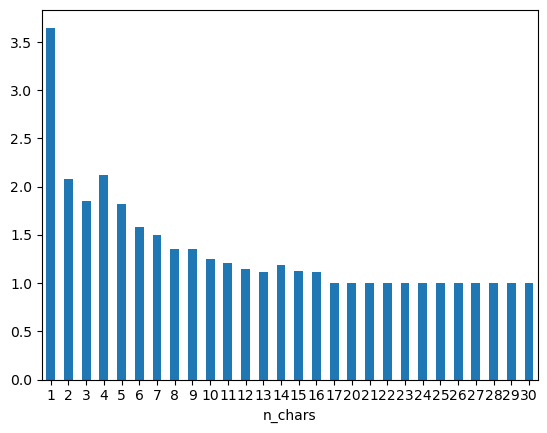

In [35]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_index().plot.bar(rot=0);

Rank Our Vocab

In [36]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank' 
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_str')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

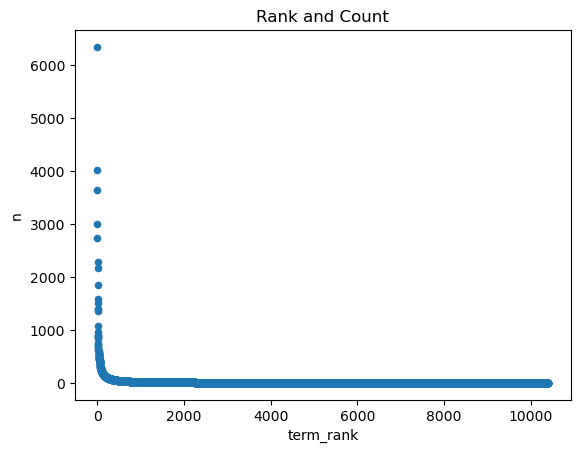

In [37]:
VOCAB.plot.scatter('term_rank', 'n', title="Rank and Count");

In [38]:
min_rank = 100
SW = VOCAB[VOCAB.term_rank <= min_rank].index.tolist()

In [39]:
# Create the 'new_rank' DataFrame
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False)\
    .reset_index()\
    .reset_index()\
    .rename(columns={'index':'term_rank2', 'count':'nn'})\
    .set_index('n')

# Aggregate duplicates by taking the first rank for each value of 'n'
new_rank = new_rank.groupby('n').first()

# Now map 'term_rank2' to VOCAB['n'] 
VOCAB['term_rank2'] = VOCAB.n.map(new_rank['term_rank2']) + 1

Top 20 Most Important Words from Vocab_Ranked

In [40]:
VOCAB.head(20).index

Index(['the', 'a', 'to', 'and', 'you', 'i', 'of', 'in', 'it', 'kroc', 'on',
       'is', 'steve', 'that', 'mark', 'with', 'ray', 'we', 'at', 'he'],
      dtype='object', name='term_str')

In [41]:
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2

In [42]:
rank_index = [1, 2, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
DEMO = VOCAB.loc[VOCAB.term_rank.isin(rank_index)][['max_pos', 'p', 'term_rank', 'term_rank2', 'i', 'zipf_k', 'zipf_k2']]

In [43]:
VOCAB['log_r'] = np.log2(VOCAB.term_rank)

## Save

In [45]:
DEMO.to_csv(f"{output_dir}/{data_prefix}-DEMO.csv")
VOCAB.to_csv(f"{output_dir}/{data_prefix}-VOCAB_RANKED.csv")
CORPUS.to_csv(f"{output_dir}/{data_prefix}-TOKEN.csv")
LIB.to_csv(f"{output_dir}/ {data_prefix}-LIB.csv")